In [1]:
import json
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from imblearn.over_sampling import SMOTE
from IPython.display import clear_output
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer as Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, f1_score, recall_score, precision_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings('ignore')

In D:\Users\Marcelo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Users\Marcelo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Users\Marcelo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In D:\Users\Marcelo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Users\Marcelo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classi

In [2]:
sys.path.append(os.path.join('..', 'src'))

In [3]:
import importlib
import utils, model, params, s05_2_feature_engineering

importlib.reload(model)
from model import get_model_params, timer, measure_prediction_time, apply_ml_model, save_model_parameters, save_model_metrics

importlib.reload(s05_2_feature_engineering)
from s05_2_feature_engineering import build_polynomials, transform_label, treat_skewness

# define functions
notice that I had to build 2 functions for xgboost. The second one applies hyperparameter tuning. 

There are some other refs for a different approach:
* https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt

In [4]:
def apply_ml_model(alg, X_train_set, y_train_set, cols, 
                   encoding='ordinal', treat_collinearity = False, build_polynomals_method=None, do_transform_label=False, 
                   do_treat_skewness=False, smote=False,
                   useTrainCV=True, cv_folds=5, early_stopping_rounds=50, verbosity=False):
    '''
     \n
     
    '''
    start_time = datetime.now()

    X_train_set = X_train_set[cols]
    
    if smote: 
        oversampling = SMOTE(sampling_strategy = 0.5, k_neighbors=5, random_state=42)
        X_train_set, y_train_set = oversampling.fit_resample(X_train_set, y_train_set)
        X_train_set = pd.DataFrame(X_train_set, columns = cols)
        
    if build_polynomals_method: 
        X_train_set = build_polynomials(X_train_set, ProjectParameters().numerical_cols, method = build_polynomals_method)
    if do_transform_label:
        y_train_set = transform_label(y_train_set, do_transform_label)
    if do_treat_skewness:
        X_train_set = treat_skewness(X_train_set, set_name)
    
    predictors = X_train_set.columns.to_list()

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train_set[predictors].values, label=y_train_set)
#         metrics = ['rmse']
        metrics = ['logloss']
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=metrics, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbosity)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train_set[predictors], y_train_set,eval_metric='auc')
        
    #Predict training set:
    X_train_set_predictions = alg.predict(X_train_set[predictors])

#     best_score = mean_squared_error(y_train_set, X_train_set_predictions)
#     best_score = accuracy_score(y_train_set, X_train_set_predictions)
    best_score = f1_score(y_train_set, X_train_set_predictions)
    
    #Print model report:
    print ("\nModel Report")
    print ("Score : %.4g" % best_score)
    
    train_time = round(timer(start_time),9)
    prediction_time = measure_prediction_time(alg, X_train_set)
    
    return alg, best_score, train_time, prediction_time, X_train_set

In [5]:
def gridsearch_and_save(model_type, models, cols, build_polynomals_method=False, 
                                            do_treat_skewness=False, smote=False): 
    ml_dict = {model_type: {}}
    grid_results = {}
    count = 0
    
    for k,model in models.items():
        
        # report step
        count += 1
        clear_output(wait=True)
        print('grid {} of {}'.format(count, len(models)))

        # apply model with parameter from grid step
        grid_results[k] = {'best_score': {}, 'train_time': {}, 'prediction_time': {}, 'best_params': {}}
        (clf,
         grid_results[k]['best_score'],
         grid_results[k]['train_time'],
         grid_results[k]['prediction_time'], 
         data_transformed) = apply_ml_model(model, X_train, y_train, columns, encoding='ordinal', 
                                            build_polynomals_method=build_polynomals_method, 
                                            do_treat_skewness=do_treat_skewness, smote=smote
                                           )

        grid_results[k]['best_params'] = clf.get_params()
        ml_dict[model_type]['columns'] = columns

    # search for best score on grid and save data and parameters
    best_score = 0
    for k,v in grid_results.items():
        score = v['best_score']
        if score >= best_score:
            best_score = score
            ml_dict[model_type]['best_score'] = v['best_score']
            ml_dict[model_type]['train_time'] = v['train_time']
            ml_dict[model_type]['prediction_time'] = v['prediction_time']
            ml_dict[model_type]['best_params'] = v['best_params']

    clear_output()
    print(best_score)
    
    save_model_parameters(models_reports, model_type, ml_dict[model_type]['best_params'])
    save_model_metrics(model_outputs, model_type, ml_dict)

#     print('Model Report')
#     print('score:', ml_dict[model_type]['best_score'])
    
    return clf

# Define paths

In [6]:
inputs = os.path.join('..', 'data', '03_processed')
outputs = os.path.join('..', 'data', '03_processed')
models_reports = os.path.join('..', 'data', '04_models')
model_outputs = os.path.join('..', 'data', '05_model_output')
reports = os.path.join('..', 'data', '06_reporting')

# Data capture
As dataset is small, we might export data to a pandas dataframe.

In [7]:
inputs = os.path.join('..', 'data', '03_processed')
models_reports = os.path.join('..', 'data', '04_models')
model_outputs = os.path.join('..', 'data', '05_model_output')
reports = os.path.join('..', 'data', '06_reporting')

# data_list = ['X_train', 'X_train_oh', 'y_train']
# dfs_dict = build_data_dict(inputs, data_list)

X_train            = pd.read_csv(os.path.join(inputs, 'X_train.csv'), index_col='id')
X_train_onehot         = pd.read_csv(os.path.join(inputs, 'X_train_onehot.csv'), index_col='id')
y_train            = pd.read_csv(os.path.join(inputs, 'y_train.csv'), index_col='id')

data_list = [X_train, X_train_onehot, y_train]

for df in data_list:
    print(df.shape)

(7000, 37)
(7000, 99)
(7000, 1)


# Machine Learning

In [8]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [9]:
imbalance_fraction = y_train[y_train['y']==0].shape[0] / y_train.shape[0]

In [19]:
import itertools
    
params = {
        'learning_rate': 0.1,
        'min_child_weight': 1,
        'scale_pos_weight': 26,
        'random_state': 42,
        'nthread': 8,
#         'scale_pos_weight': imbalance_fraction
         }
grid_params = {
        'learning_rate': [0.1, 0.01], # [0.01, 0.1]
        'n_estimators': [50, 10], # [10, 50, 100, 300], standard is 10
        'max_depth': [5, 3], # [3, 5, 10], standard is 5
        'gamma': [0], # 0, 0.01
        'subsample': [0.8, 0.6], # [0.5, 0.8]
        'colsample_bytree': [0.8, 0.6] # [0.5, 0.8]
        }

# key = 'standard'

parameter_groups = {}
keys, values = zip(*grid_params.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
for i, param_group in enumerate(permutations_dicts):
    
    objective = 'binary:logistic'
    model = XGBClassifier()
        
    for k,v in params.items(): 
        setattr(model, k, v)
    for k,v in param_group.items():
        setattr(model, k, v)
    setattr(model, 'objective', objective)
    parameter_groups[i] = model

Notice that we have a binary target. If target type was 'regression', we would have to run the following code for the param group loop:
```python
from xgboost.sklearn import XGBRegressor
objective = 'reg:squarederror'
model = XGBRegressor()
# do_transform_label=None
```

# model with all features

In [11]:
model_name = 'tree_xgb'
columns = X_train.columns.to_list()

clf = gridsearch_and_save(model_name, parameter_groups, columns)

0.49014084507042244


### feature importances

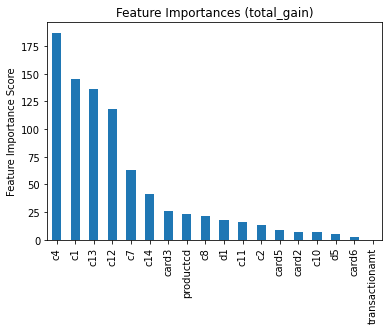

In [13]:
feature_importances = pd.Series(clf.get_booster().get_score(importance_type='total_gain')).sort_values(ascending=False)
feature_importances.head(20).plot(kind='bar', title='Feature Importances (total_gain)')
plt.ylabel('Feature Importance Score');
plt.savefig(os.path.join(reports, 'xgboost_importances_gain.jpg'), bbox_inches='tight')

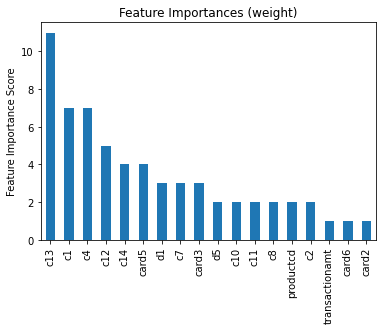

In [14]:
feature_importances = pd.Series(clf.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
feature_importances.head(20).plot(kind='bar', title='Feature Importances (weight)')
plt.ylabel('Feature Importance Score');
plt.savefig(os.path.join(reports, 'xgboost_importances_weight.jpg'), bbox_inches='tight')

# model with only card and c features

In [16]:
model_name = 'tree_xgb_select'
columns = [c for c in columns if c.startswith('addr') or c.startswith('c') ]

clf = gridsearch_and_save(model_name, parameter_groups, columns)

0.46551724137931033


### feature importances

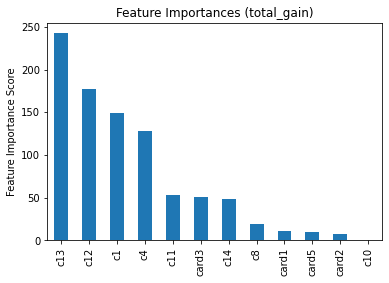

In [17]:
feature_importances = pd.Series(clf.get_booster().get_score(importance_type='total_gain')).sort_values(ascending=False)
feature_importances.head(20).plot(kind='bar', title='Feature Importances (total_gain)')
plt.ylabel('Feature Importance Score');
plt.savefig(os.path.join(reports, 'xgboost_importances_gain2.jpg'), bbox_inches='tight')

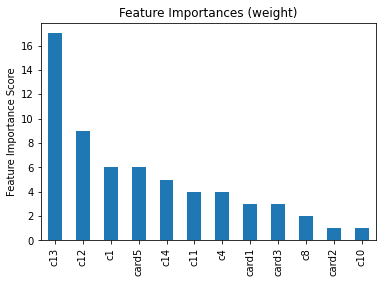

In [18]:
feature_importances = pd.Series(clf.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
feature_importances.head(20).plot(kind='bar', title='Feature Importances (weight)')
plt.ylabel('Feature Importance Score');
plt.savefig(os.path.join(reports, 'xgboost_importances_weight2.jpg'), bbox_inches='tight')

# model with only card and c features + wheighting for imbalance

In [20]:
model_name = 'tree_xgb_select_weight'
columns = [c for c in columns if c.startswith('addr') or c.startswith('c') ]

clf = gridsearch_and_save(model_name, parameter_groups, columns)

0.4846625766871166
